## Create artificial dimer data

- fit energy dependency with respect to interatomic distance calced with Quantum espresso

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
import os

from mlptools.io.read import read_from_format
from mlptools.atoms.atom import MLPAtoms
from mlptools.utils.constants import ZERO_POINT_ENERGY

In [2]:
# Fit dimer with cubic spline

path2dimer = '/Users/y1u0d2/desktop/Lab/result/qe/Si/mp-149_dimer/coord/04/result'

all_atoms = []
for d in glob(f'{path2dimer}/scf*'):
    try:
        atoms = read_from_format(d, format='espresso-in')
        all_atoms.append(atoms)
    except:
        print(d)
        continue

print(f'Number of dimer atoms: {len(all_atoms)}')

/Users/y1u0d2/desktop/Lab/result/qe/Si/mp-149_dimer/coord/04/result/scf_33
/Users/y1u0d2/desktop/Lab/result/qe/Si/mp-149_dimer/coord/04/result/scf_34
/Users/y1u0d2/desktop/Lab/result/qe/Si/mp-149_dimer/coord/04/result/scf_94
/Users/y1u0d2/desktop/Lab/result/qe/Si/mp-149_dimer/coord/04/result/scf_93
/Users/y1u0d2/desktop/Lab/result/qe/Si/mp-149_dimer/coord/04/result/scf_35
/Users/y1u0d2/desktop/Lab/result/qe/Si/mp-149_dimer/coord/04/result/scf_68
/Users/y1u0d2/desktop/Lab/result/qe/Si/mp-149_dimer/coord/04/result/scf_66
/Users/y1u0d2/desktop/Lab/result/qe/Si/mp-149_dimer/coord/04/result/scf_92
/Users/y1u0d2/desktop/Lab/result/qe/Si/mp-149_dimer/coord/04/result/scf_95
/Users/y1u0d2/desktop/Lab/result/qe/Si/mp-149_dimer/coord/04/result/scf_0
/Users/y1u0d2/desktop/Lab/result/qe/Si/mp-149_dimer/coord/04/result/scf_1
/Users/y1u0d2/desktop/Lab/result/qe/Si/mp-149_dimer/coord/04/result/scf_88
/Users/y1u0d2/desktop/Lab/result/qe/Si/mp-149_dimer/coord/04/result/scf_72
/Users/y1u0d2/desktop/Lab/r

In [3]:
dimer_info = np.array([[atoms.energy, atoms.get_atomic_distance()] for atoms in all_atoms])
dimer_df = pd.DataFrame(data=dimer_info, columns=['energy', 'distance']).sort_values(by='distance').reset_index(drop=True)
dimer_df['shifted_energy'] = dimer_df['energy'] - ZERO_POINT_ENERGY

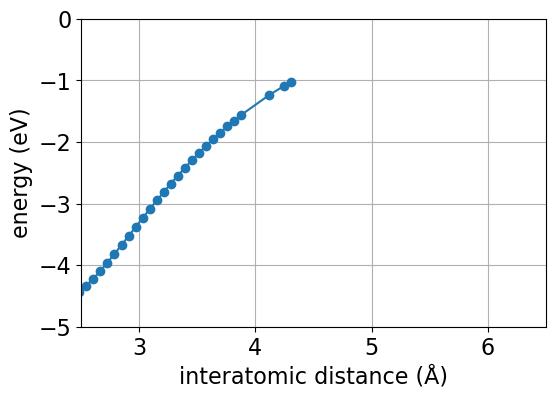

In [4]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

ax.plot(dimer_df['distance'], dimer_df['shifted_energy'], marker='o')
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_xlabel('interatomic distance (Å)', fontsize=16)
ax.set_ylabel('energy (eV)', fontsize=16)

# ax.set_ylim(-5, 20)
ax.set_ylim(-5, 00)
ax.set_xlim(2.5, 6.5)
ax.grid()

In [5]:
interpolate_qe = dimer_df.query('distance > 2.31')[['distance', 'shifted_energy']].values
convergence_term = np.vstack([np.linspace(6, 6.1, 3), np.zeros(3)]).T

artificial_data = np.array([
    [5.0, -0.45],
    [5.25, -0.27],
    [5.5, -0.15],
    [5.8, -0.05],
    [6.0, 0]
])
interpolate_qe = np.concatenate((interpolate_qe, artificial_data), axis=0)

In [6]:
from scipy.interpolate import CubicSpline

cs = CubicSpline(interpolate_qe[:, 0], interpolate_qe[:, 1])

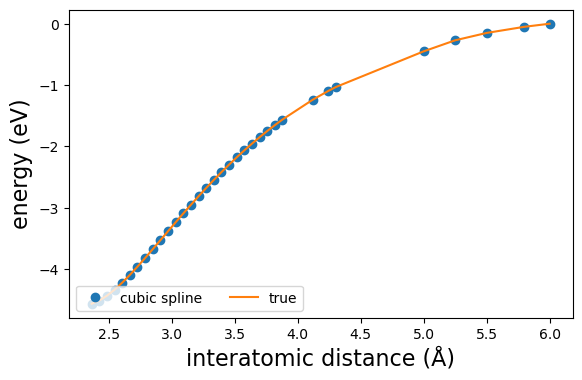

In [7]:
fig, ax = plt.subplots(figsize=(6.5, 4))
ax.plot(interpolate_qe[:, 0], cs(interpolate_qe[:, 0]), 'o', label='cubic spline')
# ax.plot(interpolate_qe[:, 0], cs(interpolate_qe[:, 0], 1), 'o', label='cubic spline1')
ax.plot(interpolate_qe[:, 0],interpolate_qe[:, 1], label='true')
ax.legend(loc='lower left', ncol=2)
ax.set_xlabel('interatomic distance (Å)', fontsize=16)
ax.set_ylabel('energy (eV)', fontsize=16)
plt.show()

In [8]:
import random

distance_lower_limit = 4.36
distance_upper_limit = 5.99
n_sample = 50

In [9]:
sampled_distances = [round(random.uniform(distance_upper_limit, distance_lower_limit), 3) for _ in range(n_sample)]
sampled_distances = list(set(sampled_distances))
sampled_energy = cs(sampled_distances)
sampled_force = cs(sampled_distances, 1)

In [10]:
all_artificial_atoms = []

for distance, energy, force in zip(sampled_distances, sampled_energy, sampled_force):
    all_artificial_atoms.append(
        MLPAtoms(
            cell=np.array([[15, 0, 0], [0, 15, 0], [0, 0, 15]]),
            coord=np.array([[7.5, 7.5, 7.5], [7.5+distance, 7.5, 7.5]]),
            energy=ZERO_POINT_ENERGY+energy,
            force=np.array([[ force, 0, 0], [-force, 0, 0]]),
            n_atoms=2,
            structure_id='mp-149_dimer',
            symbols=f'Si2'
        )
    )

In [11]:
artificial_dimer_df = pd.DataFrame(data=np.array([[atoms.energy, atoms.get_atomic_distance()] for atoms in all_artificial_atoms]), columns=['energy', 'distance']).sort_values(by='distance').reset_index(drop=True)
artificial_dimer_df['shifted_energy'] = artificial_dimer_df['energy'] - ZERO_POINT_ENERGY

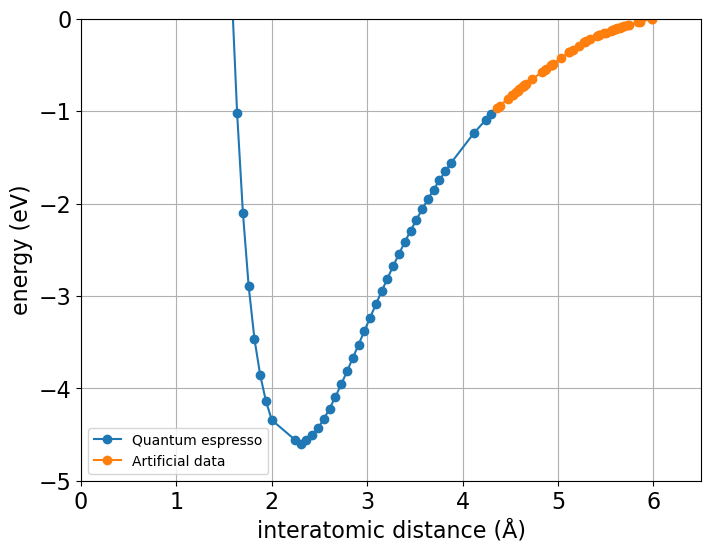

In [12]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.plot(dimer_df['distance'], dimer_df['shifted_energy'], marker='o', label='Quantum espresso')
ax.plot(artificial_dimer_df['distance'], artificial_dimer_df['shifted_energy'], marker='o', label='Artificial data')
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_xlabel('interatomic distance (Å)', fontsize=16)
ax.set_ylabel('energy (eV)', fontsize=16)
ax.legend()

# ax.set_ylim(-5, 00)
# ax.set_xlim(2.5, 6.5)
ax.set_ylim(-5, 0)
ax.set_xlim(0, 6.5)
ax.grid()

In [13]:
all_atoms += all_artificial_atoms

force_df = pd.DataFrame(data=np.array([[atoms.get_atomic_distance(), atoms.force[0][0]] for atoms in all_atoms]), columns=['distance', 'force']).sort_values(by='distance').reset_index(drop=True)

(-5.0, 5.0)

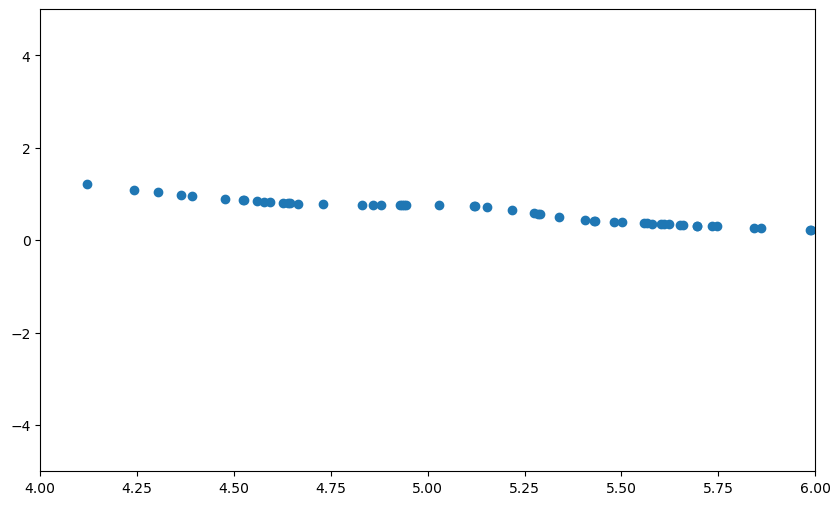

In [14]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.scatter(force_df['distance'], force_df['force'])
ax.set_xlim(4, 6)
ax.set_ylim(-5, 5)

In [15]:
force_df.query('distance > 4.0')

,distance,force
57,4.121205,1.215063
58,4.242420,1.096505
59,4.303035,1.037308
60,4.363000,0.980040
61,4.392000,0.955975
62,4.476000,0.893911
63,4.523000,0.864142
64,4.526000,0.862363
65,4.559000,0.843747
66,4.577000,0.834332


In [3]:
from mlptools.data.artificial_dimer import get_artificial_dimer

In [4]:
dimer_atoms = get_artificial_dimer(4.0, 6.0, 50)
all_atoms += dimer_atoms

Number of dimer atoms: 60


In [5]:
df = pd.DataFrame(data=np.array([[atoms.get_atomic_distance(), atoms.energy] for atoms in all_atoms]), columns=['distance', 'energy']).sort_values(by='distance').reset_index(drop=True)
df['shifted_energy'] = df['energy'] - ZERO_POINT_ENERGY

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


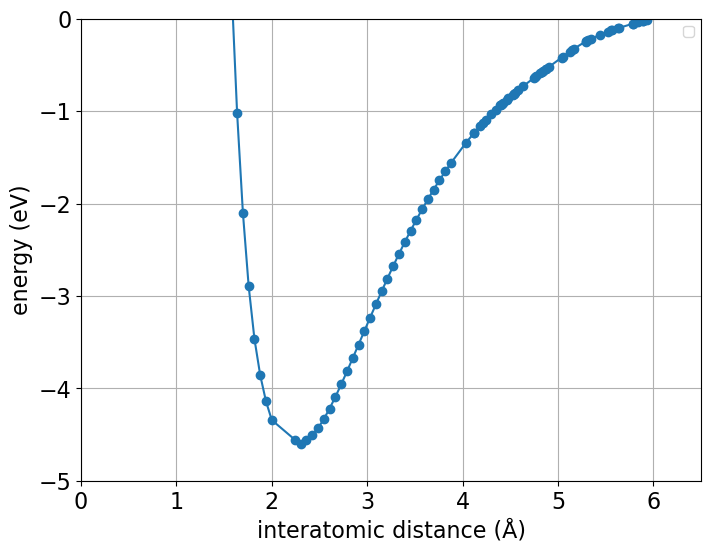

In [6]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.plot(df['distance'], df['shifted_energy'], marker='o')
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_xlabel('interatomic distance (Å)', fontsize=16)
ax.set_ylabel('energy (eV)', fontsize=16)
ax.legend()

# ax.set_ylim(-5, 00)
# ax.set_xlim(2.5, 6.5)
ax.set_ylim(-5, 0)
ax.set_xlim(0, 6.5)
ax.grid()

In [7]:
df

,distance,energy,shifted_energy
0,0.303030,-726.099133,534.041947
1,0.363630,-848.644186,411.496894
2,0.424245,-934.979392,325.161688
3,0.484845,-998.769023,261.372057
4,0.545460,-1047.660975,212.480105
...,...,...,...
102,5.785000,-1260.195331,-0.054251
103,5.843000,-1260.179297,-0.038217
104,5.890000,-1260.167083,-0.026003
105,5.891000,-1260.166830,-0.025750
